In [22]:
import os
import shutil
import random
from collections import defaultdict
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [23]:
def split_dataset_balanced_species(data_dir="data", output_dir="splits", ratios=(0.8, 0.2)):
    split_names = ['train', 'test']
    type_summary = {split: defaultdict(int) for split in split_names}

    # Prepare output dirs
    for split in split_names:
        split_path = os.path.join(output_dir, split)
        if os.path.exists(split_path):
            shutil.rmtree(split_path)
        os.makedirs(split_path)

    # Gather species per type
    type_to_species = {}
    for type_folder in os.listdir(data_dir):
        type_path = os.path.join(data_dir, type_folder)
        if not os.path.isdir(type_path):
            continue

        species_map = defaultdict(list)
        for fname in os.listdir(type_path):
            if fname.endswith('.png'):
                species = fname.split('_')[0].lower()
                species_map[species].append(os.path.join(type_path, fname))

        if len(species_map) >= 2:  # At least one for each split
            type_to_species[type_folder] = species_map

    # Determine minimum species count to balance all types
    min_species_per_type = min(len(species_map) for species_map in type_to_species.values())

    for type_folder, species_map in type_to_species.items():
        species_items = list(species_map.items())
        random.shuffle(species_items)

        balanced_species = species_items[:min_species_per_type]

        # Split species by ratios
        n = min_species_per_type
        n_train = int(n * ratios[0])
        train_sp = balanced_species[:n_train]
        test_sp = balanced_species[n_train:]

        split_assignments = {
            'train': train_sp,
            'test': test_sp
        }

        # Copy files
        for split in split_names:
            dest_dir = os.path.join(output_dir, split, type_folder)
            os.makedirs(dest_dir, exist_ok=True)
            for _, files in split_assignments[split]:
                for f in files:
                    shutil.copy(f, os.path.join(dest_dir, os.path.basename(f)))
                type_summary[split][type_folder] += 1

    # Print summary
    for split in split_names:
        print(f"\n{split.upper()}:")
        for type_folder, count in sorted(type_summary[split].items()):
            print(f"  {type_folder:<10}: {count} species")

In [ ]:
DATA_PATH = '/Users/michaelang/Downloads/3TypeCNN/'
split_dataset_balanced_species(data_dir=DATA_PATH + 'input_data/', output_dir=DATA_PATH + 'splits/', ratios=(0.8, 0.2))


TRAIN:
  Fire      : 62 species
  Grass     : 62 species
  Water     : 62 species

TEST:
  Fire      : 16 species
  Grass     : 16 species
  Water     : 16 species


In [ ]:
def load_pokemon_dataset_train_test(split_data_dir, img_size=(128, 128), normalize=True):
    """
    Loads a Pokemon dataset with train/test splits only.

    Args:
        split_data_dir (str): Path to the 'splits' directory (should contain 'train' and 'test')
        img_size (tuple): Resize target for images (height, width)
        normalize (bool): If True, scales image pixel values to [0, 1]

    Returns:
        tuple: (x_train, y_train, x_test, y_test, label_encoder)
    """
    splits = ['train', 'test']
    x_data = {split: [] for split in splits}
    y_data = {split: [] for split in splits}

    train_dir = os.path.join(split_data_dir, 'train')
    pokemon_types = [f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, f))]

    label_encoder = LabelEncoder()
    label_encoder.fit(pokemon_types)

    for split in splits:
        split_dir = os.path.join(split_data_dir, split)

        for pokemon_type in pokemon_types:
            type_dir = os.path.join(split_dir, pokemon_type)
            if not os.path.exists(type_dir):
                continue

            image_files = [f for f in os.listdir(type_dir) if f.lower().endswith('.png')]

            for img_file in image_files:
                img_path = os.path.join(type_dir, img_file)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(img_size)
                    img_array = np.array(img).flatten()

                    if normalize:
                        img_array = img_array / 255.0

                    x_data[split].append(img_array)
                    y_data[split].append(pokemon_type)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

    # Convert to numpy arrays and encode labels
    x_train = np.array(x_data['train'])
    y_train = label_encoder.transform(y_data['train'])

    x_test = np.array(x_data['test'])
    y_test = label_encoder.transform(y_data['test'])

    print(f"Train set: {len(x_train)} images")
    print(f"Test set: {len(x_test)} images")

    return x_train, y_train, x_test, y_test, label_encoder

split_data_directory = DATA_PATH + 'splits/'
x_train, y_train, x_test, y_test, label_encoder = load_pokemon_dataset_train_test(split_data_directory)

class_names = label_encoder.classes_
print("\nPokemon types (classes):")
for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")

Train set: 5144 images
Test set: 1305 images

Pokemon types (classes):
0: Fire
1: Grass
2: Water


In [26]:
type_map = {0: 'Fire', 1: 'Grass', 2: 'Water'}

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5144, 49152)
(5144,)
(1305, 49152)
(1305,)


In [27]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

y_train = y_train.ravel()
y_test = y_test.ravel()

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5144, 49152)
(1305, 49152)
(5144,)
(1305,)


In [28]:
ks = np.arange(110, 120, 2)
acc_list = []
current_acc = 0
k_max = 0

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    if acc > current_acc:
        k_max = k
        current_acc = acc
    acc_list.append(acc)
    
max_acc = max(acc_list)
print(f"Maximum accuracy: {max_acc}")
print(f"K-Neighbors: {k_max}")

Maximum accuracy: 0.4735632183908046
K-Neighbors: 112


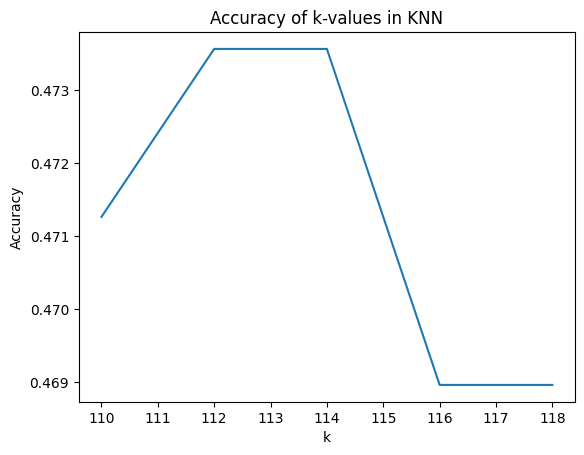

In [29]:
fig = sns.lineplot(x=ks,y=acc_list)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Accuracy of k-values in KNN")
plt.show(fig)

In [30]:
knn = KNeighborsClassifier(n_neighbors=k_max)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average="macro") * 100
precision = precision_score(y_test, y_pred, average="macro") * 100
recall = recall_score(y_test, y_pred, average="macro") * 100

results = {
    'Accuracy': acc,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

cols = ['Accuracy', 'Precision', 'Recall', 'F1']
results = [acc, precision, recall, f1]
title = f"K={k_max}"

results = pd.DataFrame(results, index=cols, columns=[title])
results.head()

,K=112
Accuracy,47.356322
Precision,47.872882
Recall,46.217175
F1,46.520412



TRAIN:
  Fire      : 62 species
  Grass     : 62 species
  Water     : 62 species

TEST:
  Fire      : 16 species
  Grass     : 16 species
  Water     : 16 species
Train set: 4819 images
Test set: 1279 images

TRAIN:
  Fire      : 62 species
  Grass     : 62 species
  Water     : 62 species

TEST:
  Fire      : 16 species
  Grass     : 16 species
  Water     : 16 species
Train set: 4956 images
Test set: 1191 images

TRAIN:
  Fire      : 62 species
  Grass     : 62 species
  Water     : 62 species

TEST:
  Fire      : 16 species
  Grass     : 16 species
  Water     : 16 species
Train set: 4940 images
Test set: 1330 images

TRAIN:
  Fire      : 62 species
  Grass     : 62 species
  Water     : 62 species

TEST:
  Fire      : 16 species
  Grass     : 16 species
  Water     : 16 species
Train set: 5008 images
Test set: 1317 images

TRAIN:
  Fire      : 62 species
  Grass     : 62 species
  Water     : 62 species

TEST:
  Fire      : 16 species
  Grass     : 16 species
  Water     : 16 spe

,Accuracy,Precision,Recall,F1 Score
1,52.541048,56.363453,52.546792,52.374142
2,53.064652,58.080762,52.391846,51.801813
3,41.879699,46.034616,41.891484,42.135344
4,51.936219,57.196275,53.856485,51.037481
5,45.394252,46.292562,45.349598,45.231279
6,54.270923,54.431087,53.980509,54.003491
Average,49.847799,53.066459,50.002786,49.430592


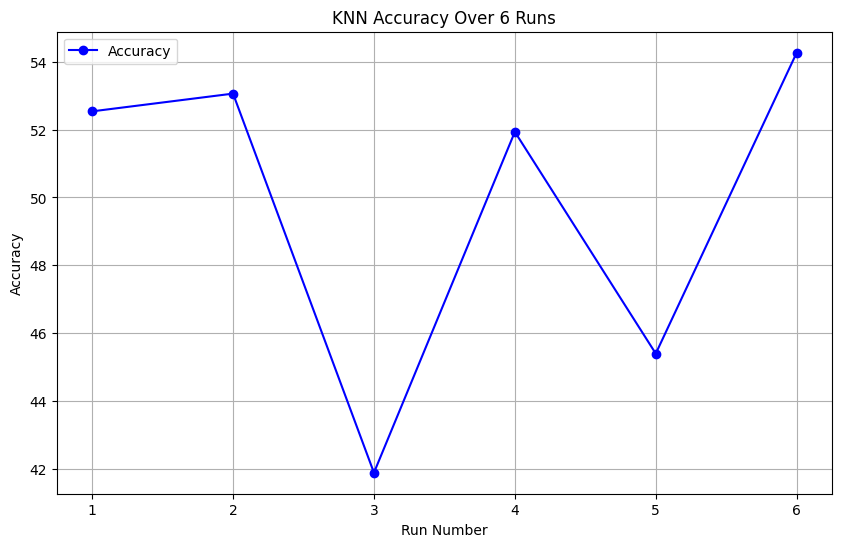

In [32]:
accuracies = []
precisions = []
recalls = []
f1s = []

for i in range(6):
    split_dataset_balanced_species(data_dir=DATA_PATH + 'input_data/', output_dir=DATA_PATH + 'splits/', ratios=(0.8, 0.2))
    x_train, y_train, x_test, y_test, label_encoder = load_pokemon_dataset_train_test(split_data_directory)
    
    knn = KNeighborsClassifier(n_neighbors=k_max)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)

    acc = accuracy_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred, average="macro") * 100
    precision = precision_score(y_test, y_pred, average="macro") * 100
    recall = recall_score(y_test, y_pred, average="macro") * 100

    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
rows = list(range(1, 7))
df = pd.DataFrame({
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1s
}, index=rows)

average_row = pd.DataFrame(df.mean(numeric_only=True)).T
average_row.index = ['Average']
df_avg = pd.concat([df, average_row])
display(df_avg)

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Accuracy'], marker='o', label='Accuracy', color='blue')
plt.xlabel('Run Number')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy Over 6 Runs')
plt.legend()
plt.grid(True)
plt.show()

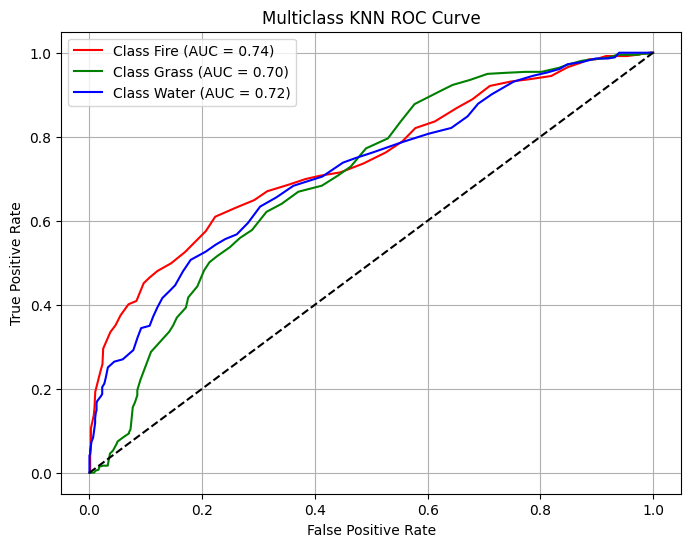

In [33]:
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

y_scores = knn.predict_proba(x_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    color = ""
    if i == 0:
        color = "red"
    elif i == 1:
        color = "green"
    else:
        color = "blue"
    plt.plot(fpr[i], tpr[i], label=f"Class {type_map[classes[i]]} (AUC = {roc_auc[i]:.2f})", color=color)

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass KNN ROC Curve")
plt.legend()
plt.grid()
plt.show()